# Exploring Adversarial Example Transferability and Robust Tree Models

Welcome to this tutorial, where we delve into the intriguing concept of adversarial example transferability. This phenomenon highlights that adversarial examples crafted to exploit one model's vulnerabilities can surprisingly fool other models as well. Our experiments on the MNIST dataset will uncover that adversarial examples ([1]) designed to attack a neural network can also confound a tree ensemble model.

Furthermore, we will present compelling evidence that Cost-Aware Robust Tree Ensemble ([2]) can effectively counteract such evasion attacks by incorporating domain-specific knowledge during training.

With the assistance of AIJack, you now have the convenient opportunity to evaluate these cutting-edge techniques effortlessly.


[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." arXiv preprint arXiv:1412.6572 (2014).

[2] Chen, Yizheng, et al. "{Cost-Aware} Robust Tree Ensembles for Security Applications." 30th USENIX Security Symposium (USENIX Security 21). 2021.

In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aijack.attack.evasion import FGSMAttacker
from aijack.collaborative.tree import (
    XGBoostClassifierAPI,
    XGBoostClient,
)
from aijack.utils import NumpyDataset

BASE = "data/"
torch.manual_seed(42)

In [3]:
mnist_dataset_train = torchvision.datasets.MNIST(root="", train=True, download=True)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

X = mnist_dataset_train.train_data.numpy()
y = mnist_dataset_train.train_labels.numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=True
)

X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[:1000]
y_test = y_test[:1000]

train_dataset = NumpyDataset(
    X_train,
    y_train,
    transform=transform,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)

test_dataset = NumpyDataset(
    X_test,
    y_test,
    transform=transform,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 66438329.26it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64331223.49it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22731323.10it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5683331.97it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 10)
        # self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        return x

In [5]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [6]:
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")


in_preds = []
in_label = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "\nTest Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

epoch 0: loss is 0.06138062975555658
epoch 1: loss is 0.03086455798149109
epoch 2: loss is 0.026004610773175955
epoch 3: loss is 0.024114671636372806
epoch 4: loss is 0.02078699535317719
epoch 5: loss is 0.019672507184557618
epoch 6: loss is 0.018815230432897807
epoch 7: loss is 0.01698792629688978
epoch 8: loss is 0.01645607683621347
epoch 9: loss is 0.01524037384428084
epoch 10: loss is 0.014240541556850075
epoch 11: loss is 0.013692389758303761
epoch 12: loss is 0.012920912820845842
epoch 13: loss is 0.012520179092884064
epoch 14: loss is 0.012519657954573632
epoch 15: loss is 0.011793930067680775
epoch 16: loss is 0.011448755952529609
epoch 17: loss is 0.010951191697269679
epoch 18: loss is 0.010661566779017449
epoch 19: loss is 0.010179236607626081
epoch 20: loss is 0.009936179189942777
epoch 21: loss is 0.009754820148460568
epoch 22: loss is 0.00917115265596658
epoch 23: loss is 0.009030795649625362
epoch 24: loss is 0.008823388266377151
epoch 25: loss is 0.008829819331876933
epo

## FGSM Attack against NN

In [7]:
x_origin = inputs[[0]]
y_origin = labels[[0]]

attacker = FGSMAttacker(
    net, criterion, eps=0.3, grad_lower_bound=-0.15, grad_upper_bound=0.15
)
perturbed_x = attacker.attack((x_origin, y_origin.to(torch.int64)))

(-0.5, 27.5, 27.5, -0.5)

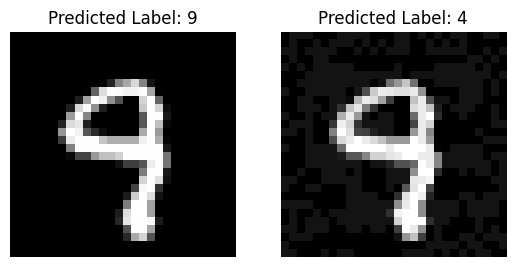

In [8]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(x_origin[0][0].detach().numpy(), cmap="gray", vmin=-1.0, vmax=1.0)
plt.title(f"Predicted Label: {net(x_origin).argmax().item()}")
plt.axis("off")
fig.add_subplot(122)
plt.imshow(perturbed_x[0][0].detach().numpy(), cmap="gray", vmin=-1.0, vmax=1.0)
plt.title(f"Predicted Label: {net(perturbed_x).argmax().item()}")
plt.axis("off")

## XGBoost without Defense

The adversarial example crafted above can also deceive the XGBoost model.

In [9]:
min_leaf = 1
depth = 6
learning_rate = 0.3
boosting_rounds = 10
lam = 1.0
gamma = 0.0
eps = 1.0
min_child_weight = -1 * float("inf")
subsample_cols = 0.8

X_train_normalized = ((X_train / 255) * 2 - 1).reshape(-1, 28 * 28).tolist()
X_test_normalized = ((X_test / 255) * 2 - 1).reshape(-1, 28 * 28).tolist()

p0 = XGBoostClient(
    X_train_normalized,
    10,
    list(range(28 * 28)),
    0,
    min_leaf,
    subsample_cols,
    32,
    False,
    0,
)
parties = [p0]

clf = XGBoostClassifierAPI(
    10,
    subsample_cols,
    min_child_weight,
    depth,
    min_leaf,
    learning_rate,
    boosting_rounds,
    lam,
    gamma,
    eps,
    -1,
    0,
    1.0,
    1,
    True,
    False,
)
clf.fit(parties, y_train.tolist())

predicted_proba = clf.predict_proba(X_train_normalized)
print(
    "Train Accuracy: ",
    accuracy_score(np.array(predicted_proba).argmax(axis=1), y_train),
)
predicted_proba = clf.predict_proba(X_test_normalized)
print(
    "Test Accuracy: ", accuracy_score(np.array(predicted_proba).argmax(axis=1), y_test)
)

print(
    "Predicted Label without Attack: ",
    np.array(
        clf.predict_proba(x_origin[0][0].detach().numpy().reshape(1, -1).tolist())
    ).argmax(1),
)
print(
    "Predicted Label with Attack: ",
    np.array(
        clf.predict_proba(perturbed_x[0][0].detach().numpy().reshape(1, -1).tolist())
    ).argmax(1),
)

Train Accuracy:  0.998
Test Accuracy:  0.836
Predicted Label without Attack:  [9]
Predicted Label with Attack:  [5]


## XGBoost using Attack-Cost Constraints

In [10]:
p0 = XGBoostClient(
    X_train_normalized,
    10,
    list(range(28 * 28)),
    0,
    min_leaf,
    subsample_cols,
    32,
    False,
    0,
)
# You can set the attack-cost constraint to each feature
p0.set_cost_constraint_map([(-0.2, 0.2)] * (28 * 28))
parties = [p0]

clf = XGBoostClassifierAPI(
    10,
    subsample_cols,
    min_child_weight,
    depth,
    min_leaf,
    learning_rate,
    boosting_rounds,
    lam,
    gamma,
    eps,
    -1,
    0,
    1.0,
    1,
    True,
    True,
)
clf.fit(parties, y_train.tolist())

predicted_proba = clf.predict_proba(X_train_normalized)
print(
    "Train Accuracy: ",
    accuracy_score(np.array(predicted_proba).argmax(axis=1), y_train),
)
predicted_proba = clf.predict_proba(X_test_normalized)
print(
    "Test Accuracy: ", accuracy_score(np.array(predicted_proba).argmax(axis=1), y_test)
)

print(
    "Predicted Label without Attack: ",
    np.array(
        clf.predict_proba(x_origin[0][0].detach().numpy().reshape(1, -1).tolist())
    ).argmax(1),
)
print(
    "Predicted Label with Attack: ",
    np.array(
        clf.predict_proba(perturbed_x[0][0].detach().numpy().reshape(1, -1).tolist())
    ).argmax(1),
)

Train Accuracy:  0.975
Test Accuracy:  0.84
Predicted Label without Attack:  [9]
Predicted Label with Attack:  [9]
